<a href="https://colab.research.google.com/github/jalbury/machine-learning/blob/master/HW_4/HW4_Problem3a_John_Albury.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Description of changes

This is the first of two notebooks that will modify Dr. Wocjan's code to use a different convolution base for feature extraction. Specifically, I changed the convolutional base of the model from [VGG16](https://keras.io/applications/#vgg16) to [InceptionV3](https://keras.io/applications/#inceptionv3)

For this first notebook, I used a classifier with two `Dense` layers: one with 256 neurons and one with 128 neurons. The results were a validation loss of 0.32 and a validation accuracy of 0.89. In the next notebook, I will attempt to improve on these results.

# Fine-tuning VGG16 

This is based on section 5.3 *Using a pretrained convnet* of the book *Deep learning with Python* by Francois Chollet. I have made several changes to the code. I use the data that is already provided by Google. I don't download the data from Kaggle as in the deep learning book.

## Feature extraction

Feature extraction consists of using the representations learned by a previous network to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch.

We will use here the convolutional base of the InceptionV3 model to extract the features. We will feed these features to a densely connected classifier with dropout. We will fine-tune some layers.

## Download the data

Download the example data, a zip. of 2,000 JPG pictures of cats and dogs and extract it locally in ```/tmp```.



In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2020-04-18 17:49:10--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.79.128, 2a00:1450:4013:c04::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.79.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   159MB/s    in 0.4s    

2020-04-18 17:49:10 (159 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

Note that the data provided by Google does not have a test set.

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

## Build network with InceptionV3 convolution base and custom densely connected layers

### Load the convolutional base

In [6]:
from keras.applications import InceptionV3

conv_base = InceptionV3(
    weights='imagenet', 
    include_top=False, 
    input_shape=(150, 150, 3))

Using TensorFlow backend.


87916544/87910968 [==============================] - 3s 0us/step


### Freeze the convolutional base

In [0]:
conv_base.trainable = False

### Concatenate the convolutional base and densely connected layers

In [0]:
from keras import layers
from keras import models
from keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [9]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten_1 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               4718848   
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 26,554,657
Trainable params: 4,751,873
Non-trainable params: 21,802,784
_________________________________________________________________


## Train the model end to end with frozen convolutional base

In [10]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

# data augmentation

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

# compile model

model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.RMSprop(lr=2e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 29s 286ms/step - loss: 0.5925 - acc: 0.6580 - val_loss: 0.2760 - val_acc: 0.9150
Epoch 2/30
100/100 [==============================] - 17s 174ms/step - loss: 0.5047 - acc: 0.7480 - val_loss: 0.0445 - val_acc: 0.9290
Epoch 3/30
100/100 [==============================] - 17s 175ms/step - loss: 0.4613 - acc: 0.7795 - val_loss: 0.0080 - val_acc: 0.9460
Epoch 4/30
100/100 [==============================] - 18s 176ms/step - loss: 0.4449 - acc: 0.7845 - val_loss: 0.1890 - val_acc: 0.9450
Epoch 5/30
100/100 [==============================] - 18s 175ms/step - loss: 0.4353 - acc: 0.8025 - val_loss: 0.5954 - val_acc: 0.8960
Epoch 6/30
100/100 [==============================] - 17s 175ms/step - loss: 0.4377 - acc: 0.7985 - val_loss: 0.1824 - val_acc: 0.9430
Epoch 7/30
100/100 [==============================] - 17s 174ms/step - loss: 0.4034 - acc: 0.8150 - val_lo

## Display curves of loss and accuracy during training

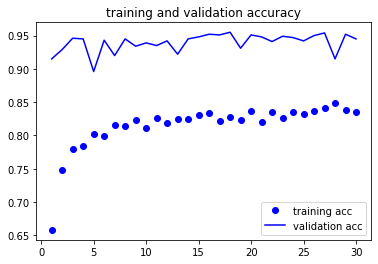

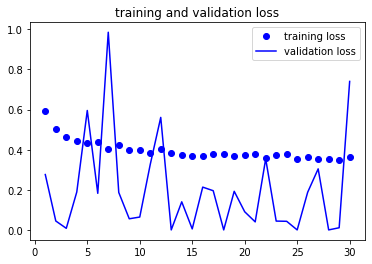

In [11]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

## Fine-tuning

In [0]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'conv2d_188':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [13]:
# compile model

model.compile(
    loss='binary_crossentropy',
    #
    # choose a smaller learning rate
    #
    optimizer=optimizers.RMSprop(lr=1e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/100
100/100 [==============================] - 24s 242ms/step - loss: 0.3577 - acc: 0.8360 - val_loss: 0.1070 - val_acc: 0.9280
Epoch 2/100
100/100 [==============================] - 18s 185ms/step - loss: 0.3235 - acc: 0.8545 - val_loss: 0.3288 - val_acc: 0.8970
Epoch 3/100
100/100 [==============================] - 19s 186ms/step - loss: 0.3455 - acc: 0.8445 - val_loss: 0.3502 - val_acc: 0.8830
Epoch 4/100
100/100 [==============================] - 19s 188ms/step - loss: 0.3351 - acc: 0.8460 - val_loss: 0.1181 - val_acc: 0.8790
Epoch 5/100
100/100 [==============================] - 19s 186ms/step - loss: 0.3348 - acc: 0.8485 - val_loss: 0.2316 - val_acc: 0.8940
Epoch 6/100
100/100 [==============================] - 19s 186ms/step - loss: 0.3435 - acc: 0.8345 - val_loss: 0.1112 - val_acc: 0.8860
Epoch 7/100
100/100 [==============================] - 19s 186ms/step - loss: 0.3251 - acc: 0.8530 - val_loss: 0.4032 - val_acc: 0.8870
Epoch 8/100
100/100 [===========================

## Display learning curves during fine-tuning

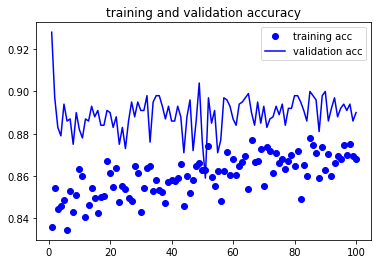

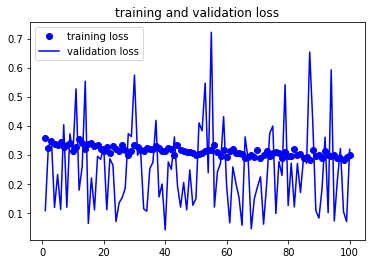

In [14]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

This looks like underfitting. In the next notebook, I will aim to improve accuracy by making the classifier more complex.

## Print out validation loss and accuracy

In [0]:
val_loss, val_acc = model.evaluate_generator(validation_generator, steps=50)

In [16]:
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

Validation loss: 0.3183101713657379
Validation accuracy: 0.8899999856948853
